In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import rc
import math
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 13})
rc('text', usetex=True)
####reactivity parametrization of DT, D3He, DDp, DDn, TT, 3He3He reactions
## Belov et al 2019
def react(T, channel):
    if channel == 'tt':
        return 5.41*1e-14*T**(-2/3)*np.exp(-21.52/T**(1/3))
    elif channel == '3he3he':
        return 1.93*1e-12*T**(-2/3)*np.exp(-54.22/T**(1/3))
    else:
        if channel == 'dt':
            ksi =  np.array([-42.559, 33.312, -9.876,  2.501, -0.414, 0.0,   0.0])
            neta = np.array([0.0,     24.394, -16.909, 7.406, -2.148, 0.411, 0.0])
        if channel == 'd3he':
            ksi =  np.array([-60.504, 53.039, -16.233, 3.980, -0.749, 0.0, 0.004])
            neta = np.array([0.0,     43.244, -31.497, 15.707, -6.055, 1.734, -0.319])
        if channel == 'ddp':
            ksi =  np.array([-41.898, 30.017, -9.150,  2.140, -0.316, 0.0,   0.012])
            neta = np.array([0.0,     24.313, -16.995, 7.572, -2.540, 0.580, -0.068])
        if channel == 'ddn':
            ksi =  np.array([-42.145, 30.484, -9.451,  2.265, -0.346, 0.0,   0.015])
            neta = np.array([0.0,     24.459, -17.170, 7.744, -2.655, 0.630, -0.079])
        t = (np.pi/5.30)*(np.log10(T*1000) -3.65)
        s = sum(ksi[k]*np.cos(k*t)+neta[k]*np.sin(k*t) for k in range(len(ksi)))
        return np.power(10, s)
### System of particle and energy balance equations 
def F(s,t_int):    
    # Fusion reaction rates
    r_dd_p = react(s[0],'ddp') 
    r_dd_n = react(s[0],'ddn') 
    r_dt =   react(s[0],'dt')
    r_d3he = react(s[0],'d3he')    
    r_dd =   react(s[0],'ddp') + react(s[0],'ddn')
    r_tt =   react(s[0],'tt')
    r_3he3he=react(s[0],'3he3he')
    # Q values and energies for fusion reactions in MeV
    Q_ddp = 4.03; Q_ddn = 3.27; Q_d3he = 18.35;
    E_ddn = 0.82; E_adt = 3.52; E_n1 = 2.45;   E_n2 = 14.07;
    E_att = 3.7766 ; Q3he3he = 12.86; En34 = (2/3)*11.33    
    te = 6.8
    rho = 6
    floss = 0.25
    # D, T and 3He densities in cm^-3
    nd   = -1.0*r_dd   * s[1]*s[1] - r_dt  *s[1]*s[2] -r_d3he*s[1]*s[3] - s[1]/(rho*te)
    nt   = +0.5*r_dd_p * s[1]*s[1] - r_dt  *s[1]*s[2] - 1.0*r_tt*s[2]*s[2] - s[2]/(rho*te)
    n3he = +0.5*r_dd_n * s[1]*s[1] - r_d3he*s[1]*s[3] - 1.0*r_3he3he*s[3]*s[3] - s[3]/(rho*te)
    na = (1-floss)*(r_dt  *s[1]*s[2] +r_d3he*s[1]*s[3] + 0.5*r_3he3he*s[3]*s[3] + 0.5*r_tt*s[2]*s[2]) - s[4]/(rho*te)
    np = 0.5*r_dd_p * s[1]*s[1] + r_d3he*s[1]*s[3] + 1.0*r_3he3he*s[3]*s[3] - s[5]/(rho*te)
    #nn = 0.5*r_dd_n * s[1]*s[1] + r_dt  *s[1]*s[2] + 1.0*r_tt*s[2]*s[2]
    
    ne = nd + nt + 2*n3he + 2*na + np
    ntot = s[1]+s[2]+s[3]+s[4]+s[5]+s[6]
    dntot = nd + nt + n3he + na + np + ne
    # Energy yield in MeV/cm^3 for charged particles
    Ech =  (0.5*r_dd_p * s[1]*s[1]* Q_ddp + r_dt  * s[1]*s[2]* E_adt+
            0.5*r_dd_n * s[1]*s[1]* E_ddn + r_d3he* s[1]*s[3]* Q_d3he+
            0.5*r_3he3he*s[3]*s[3]*Q3he3he + 0.5*r_tt*s[2]*s[2]*E_att)
 
    # Energy yield in MeV/cm^3 for Neutrons
    En =    (0.5*r_dd_n * s[1]*s[1]* E_n1 +  r_dt * s[1]*s[2]* E_n2 +
             0.5*r_tt*s[2]*s[2]*En34)
    
    ###Bremsstrahlung power radiation losses in Mev/cm^3
    Pbr = 0.343283e-17*(s[0])**(0.5)*(s[1]+s[2]+4*s[3]+4*s[4]+s[5])*s[6]
    # Energy confinement loss per unit of time tau
    dE = 1.5*s[0]*1e-3*ntot/te
    ### Temperature in keV
    T = (2/3)*1e+3*((Ech-Pbr-dE)*ntot-dntot*(s[7]-s[9]-s[10]))/ntot**2    
    return [T, nd, nt, n3he, na, np, ne, Ech, En, Pbr, dE]

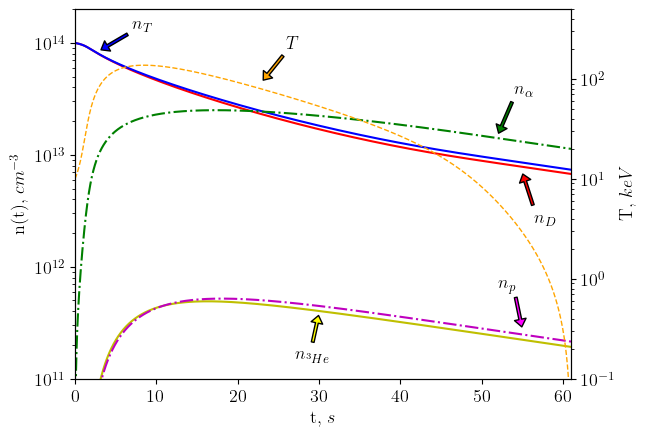

In [2]:
t_min = 0  # start-time in seconds
t_max = 61 # finish-time in seconds
t_int = np.linspace(t_min,t_max, 100000) # number of time intervals
#[T, nd, nt, n3he, Ech, En, Ebr]  initial values
n0=[10,1e+14, 1e+14, 0, 0, 0, 2e+14, 0, 0, 0, 0] 
s = odeint(F,n0,t_int)
fig, ax1 = plt.subplots()
ax1.plot(t_int,s[:,1],'r-', linewidth=1.5)
ax1.plot(t_int,s[:,2],'b-', linewidth=1.5)
ax1.plot(t_int,s[:,3],'y-', linewidth=1.5)
ax1.plot(t_int,s[:,4],'g-.', linewidth=1.5)
ax1.plot(t_int,s[:,5],'m-.', linewidth=1.5)
ax1.set(xlabel='t, $s$',ylabel ='n(t), $cm^{-3}$',xlim=[t_min,t_max], ylim=[1e+11, 2e+14], yscale = 'log')
#ax1.set(xscale = 'log')
#ax1.legend(['$n_{D}$', '$n_{T}$', '$n_{^{3}He}$', r'$n_{\alpha}$', '$n_{p}$'], 
#           loc = 'lower center')
ax2 = ax1.twinx()
ax2.plot(t_int,s[:,0],'--', color='orange', linewidth=1.0)
ax2.set(ylabel = 'T, $keV$', yscale ='log', ylim = [1e-1, 5e+2])
#ax2.legend(['T [keV]'], loc = 'upper right')
ax1.annotate('$n_{T}$', xy=(3,8.5e+13),xytext=(7, 13.5e+13), 
             arrowprops=dict(facecolor='blue', shrink=0.05, 
             width=2.0, headwidth=8.5, headlength=5.5))
ax1.annotate('$n_{D}$', xy=(55,7e+12),xytext=(56.5, 2.5e+12), 
             arrowprops=dict(facecolor='red', shrink=0.05, 
             width=2.0, headwidth=8.5, headlength=5.5))
ax1.annotate(r'$n_{\alpha}$', xy=(52,1.5e+13),xytext=(54, 3.5e+13), 
             arrowprops=dict(facecolor='green', shrink=0.05, 
             width=2.0, headwidth=8.5, headlength=5.5))
ax1.annotate('$n_{^{3}He}$', xy=(30,3.8e+11),xytext=(27, 1.5e+11), 
             arrowprops=dict(facecolor='yellow', shrink=0.05, 
             width=2.0, headwidth=8.5, headlength=5.5))
ax1.annotate('$n_{p}$', xy=(55,2.8e+11),xytext=(52, 6.5e+11), 
             arrowprops=dict(facecolor='magenta', shrink=0.05, 
             width=2.0, headwidth=8.5, headlength=5.5))
ax1.annotate('$T$', xy=(23,4.5e+13),xytext=(26, 9e+13), 
             arrowprops=dict(facecolor='orange', shrink=0.05, 
             width=2.0, headwidth=8.5, headlength=5.5))
#plt.savefig('DTfuel_burn.jpg', dpi= 1000,bbox_inches='tight')
plt.show()

In [3]:
print('T_max = '+str(round(max(s[:, 0])*100)/100)+' keV')
print('time of Tmax = '+str(t_int[np.argmax(s[:,0])])+' sec')

T_max = 137.4 keV
time of Tmax = 8.491894918949189 sec


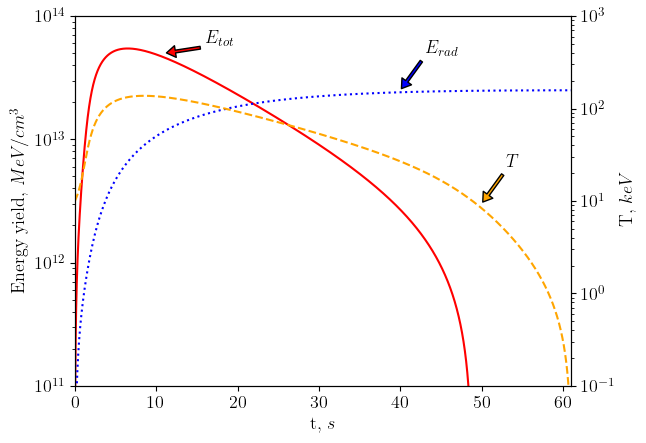

In [4]:
fix, ax1 = plt.subplots()
ax1.plot(t_int,s[:,7]-s[:,9]-s[:,10],'r-', linewidth=1.5)
ax1.plot(t_int,s[:,9],'b:', linewidth=1.5)
ax1.set(xlabel = 't, $s$', ylabel = 'Energy yield, $MeV/cm^{3}$', 
       xlim=[t_min,t_max], yscale = 'log', ylim=[1e+11,1e+14])
#ax1.legend(['E$_{tot}$', 'E$_{rad}$'])
ax2 = ax1.twinx()
ax2.plot(t_int,s[:,0],'--', color='orange', linewidth=1.5)
ax2.set(ylabel = 'T, $keV$', yscale ='log', ylim = [1e-1, 1e+3])
ax1.annotate('$E_{tot}$', xy=(11,5e+13),xytext=(16, 6e+13), 
             arrowprops=dict(facecolor='red', shrink=0.05, 
             width=2.0, headwidth=8.5, headlength=6.5))
ax1.annotate('$E_{rad}$', xy=(40,2.5e+13),xytext=(43, 5e+13), 
             arrowprops=dict(facecolor='blue', shrink=0.05, 
             width=2.0, headwidth=8.5, headlength=6.5))
ax1.annotate('$T$', xy=(50,3e+12),xytext=(53, 6e+12), 
             arrowprops=dict(facecolor='orange', shrink=0.05, 
             width=2.0, headwidth=8.5, headlength=6.5))
#plt.savefig('DT_energy.jpg', dpi= 1000,bbox_inches='tight')
plt.show()